# ECoG Data Preparation

**Authors:** KHOO Jing Heng, Zayne SIEW

**Version:** 1.0 (26/03/2025)

### About this notebook

This notebook is used to load and process ECoG and finger flexion data from the BCI IV Competition dataset 4.

The ECoG data corresponds to the brainwave activity recorded by the participant during the experiment,
while the finger flexion data corresponds to the data-glove results collected during the experiment.
Both sets of data are sampled at different frequencies and require preprocessing to synchronize accordingly.

### Requirements

- Python 3
- Matplotlib
- Numpy
- MNE
- Scipy
- Scikit-learn
- Torch

## 0. Imports and Torch-CUDA Config

In [1]:
import numpy as np

from mne import create_info
from mne.io import RawArray
from mne.time_frequency import tfr_array_morlet

from scipy.io import loadmat
from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler, RobustScaler

import torch
from torch.utils.data import DataLoader

from constants import (
    SUBJECT_ID,
    CHANNELS_NUM,
    ECOG_TRAIN_FILEPATH,
    ECOG_VAL_FILEPATH,
    FLEXION_TRAIN_FILEPATH,
    FLEXION_VAL_FILEPATH,
    SAMPLE_RATE,
    TIME_DELAY_SEC,
    WAVELET_NUM,
)
from data import EcogDataset, plot_ecog_data

In [2]:
print(SUBJECT_ID)

sub2


In [3]:
# For windows/linux will try CUDA first, then CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Set default device for following code, so we don't need to specify device every time
torch.set_default_device(DEVICE)

cuda


## 1. Data Preprocessing

The functions describe the preprocessing steps for the finger flexion and ECoG data respectively.

In [4]:
def finger_flex_preprocess(
    finger_flex: np.ndarray,
    original_hz: int = 1000,
    actual_hz: int = 25,
    upsampled_hz: int = SAMPLE_RATE,
) -> np.ndarray:
    """Resample finger flexion data to desired `upsampled_hz` frequency from its original frequency.

    Preprocessing steps include:
    - Downsampling to 25Hz, matching the original data-glove collection frequency
    - Interpolation to upsample to our target frequency of 100Hz
    - MinMax normalization

    Parameters:
        finger_flex (np.ndarray):
            Finger flexion data to resample.
        original_hz (int, default=1000):
            Original sampling frequency (in Hz) of the finger flexion data.
        actual_hz (int, default=25):
            Actual labelling frequency (in Hz) of the finger flexion data.
        upsampled_hz (int, default=SAMPLE_RATE):
            Desired sampling frequency (in Hz) of the finger flexion data.

    Returns:
        np.ndarray:
            The resampled finger flexion data.
    """

    downscaling_ratio = original_hz // actual_hz
    finger_flex = finger_flex[:, ::downscaling_ratio]

    print(upsampled_hz)

    # Time vectors for interpolation
    old_time = np.linspace(0, finger_flex.shape[1] - 1, num=finger_flex.shape[1])
    new_time = np.linspace(0, finger_flex.shape[1] - 1, num=int(finger_flex.shape[1] * (upsampled_hz / actual_hz)))

    # Apply cubic interpolation
    interpolator = interp1d(old_time, finger_flex, kind="cubic", axis=1)
    finger_flex_interp = interpolator(new_time)

    scaler = MinMaxScaler(feature_range=(0, 1))
    finger_flex_scaled = scaler.fit_transform(finger_flex_interp.T).T

    return finger_flex_scaled

In [5]:
def ecog_preprocess(train: np.ndarray) -> np.ndarray:
    """Transform ECoG data from pure timeseries-based to spectrogram.

    Preprocessing steps include:
    - Z-score normalization by channel (subtract mean, divide by standard deviation)
    - Median subtraction to reduce common artifacts
    - Bandpass filtering from 40Hz to 300Hz using a FIR filter
    - Notch filtering at frequencies (50Hz, 100Hz, etc. up to 450Hz) to remove line noise
    - Time-frequency transformation using Morlet wavelets to create spectrograms in the 40-300Hz range
    - Downsampling from the original 1000Hz to our target sample rate
    - Robust scaling of the spectrogram data to reduce sensitivity to outliers

    Parameters:
        train (np.ndarray):
            The (training) ECoG data to preprocess.

    Returns:
        np.ndarray:
            Scaled spectrogram of the ECoG data.
    """

    original_sfreq = 1000
    ch_names = [f"ch{i}" for i in range(1, CHANNELS_NUM + 1)]
    ch_types = ["ecog"] * CHANNELS_NUM  # Mark all channels as ECoG

    train = (train - np.mean(train, axis=1, keepdims=True)) / np.std(train, axis=1, keepdims=True)
    medians = np.median(train, axis=0, keepdims=True)
    train = train - medians

    info = create_info(ch_names=ch_names, sfreq=original_sfreq, ch_types=ch_types)

    raw = RawArray(train, info)
    raw.filter(l_freq=40, h_freq=300, fir_design='firwin')
    raw.notch_filter(freqs=[50, 100, 150, 200, 250, 300, 350, 400, 450], fir_design='firwin')

    X = raw.get_data()

    X = X[np.newaxis, :, :]

    X_spectrogram = tfr_array_morlet(
        X, sfreq=original_sfreq, freqs=np.logspace(np.log10(40), np.log10(300), WAVELET_NUM), output="power"
    )

    X_spectrogram = X_spectrogram[0]

    downscaling_ratio = original_sfreq // SAMPLE_RATE
    X_spectrogram = X_spectrogram[:, :, ::downscaling_ratio]

    num_channels, num_freqs, num_time_steps = X_spectrogram.shape
    X_spectrogram = X_spectrogram.T.reshape(-1, num_freqs*num_channels)

    scaler = RobustScaler(unit_variance=True, quantile_range=(0.1, 0.9))

    X_spectrogram_scaled = scaler.fit_transform(X_spectrogram)
    X_spectrogram_scaled = X_spectrogram_scaled.reshape(-1, num_freqs, num_channels).T

    print("Scaled Spectrogram Shape:", X_spectrogram_scaled.shape)

    return X_spectrogram_scaled

In [6]:
def crop_for_time_delay(
    finger_flex: np.ndarray,
    spectrogramms: np.ndarray,
    time_delay_sec: float = TIME_DELAY_SEC,
    sample_rate: int = SAMPLE_RATE,
) -> tuple[np.ndarray, np.ndarray]:
    """Crops both the finger flexion and ECoG data to account for the brainwave-motor function delay.

    Parameters:
        finger_flex (np.ndarray):
            (Preprocessed) finger flexion data.
        spectrogramms (np.ndarray):
            (Preprocessed) ECoG data, as a scaled spectrogram.
        time_delay_sec (float, default=TIME_DELAY_SEC):
            Brainwave-motor function delay.
        sample_rate (int, default=SAMPLE_RATE):
            Desired synchronized sampling rate.

    Returns:
        The cropped finger flexion and spectrogram data respectively.
    """

    time_delay = int(time_delay_sec*sample_rate)
    # The first time_delay seconds of finger flex data have no corresponding spectrograms
    finger_flex_cropped = finger_flex[..., time_delay:]
    # The last time_delay seconds of spectrograms have no corresponding finger flex data
    spectrogramms_cropped = spectrogramms[..., :spectrogramms.shape[2] - time_delay]
    return finger_flex_cropped, spectrogramms_cropped

## 2. Data Handling

This section handles the loading, preprocessing, and saving of the data.

In [7]:
# Define directory where data is stored
DATA_DIR = "../data"

In [8]:
data: dict[str, np.ndarray] = loadmat(f'{DATA_DIR}/{SUBJECT_ID}_comp.mat')

finger_flex = data['train_dg'].astype('float32').T
finger_flex = finger_flex_preprocess(finger_flex)
print("Shape:", finger_flex.shape)

100
Shape: (5, 40000)


In [9]:
train = data['train_data'].astype('float32').T
X_spectrogram = ecog_preprocess(train)
print("Shape:", X_spectrogram.shape)

Creating RawArray with float64 data, n_channels=48, n_times=400000
    Range : 0 ... 399999 =      0.000 ...   399.999 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   21.8s


Scaled Spectrogram Shape: (48, 40, 40000)
Shape: (48, 40, 40000)


In [10]:
finger_flex_cropped, X_spectrogram_cropped = crop_for_time_delay(finger_flex, X_spectrogram)

print(finger_flex_cropped.shape, X_spectrogram_cropped.shape)

(5, 39980) (48, 40, 39980)


In [11]:
data_val = loadmat(f'{DATA_DIR}/{SUBJECT_ID}_testlabels.mat')
finger_flex_val = data_val['test_dg'].astype('float32').T
finger_flex_val = finger_flex_preprocess(finger_flex_val)
print("Shape:", finger_flex_val.shape)

100
Shape: (5, 20000)


In [12]:
val = data['test_data'].astype('float32').T
X_spectrogram_val = ecog_preprocess(val)

Creating RawArray with float64 data, n_channels=48, n_times=200000
    Range : 0 ... 199999 =      0.000 ...   199.999 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    9.6s


Scaled Spectrogram Shape: (48, 40, 20000)


In [13]:
finger_flex_cropped_val, X_spectrogram_cropped_val = crop_for_time_delay(finger_flex_val, X_spectrogram_val)

print(finger_flex_cropped_val.shape, X_spectrogram_cropped_val.shape)

(5, 19980) (48, 40, 19980)


In [14]:
np.save(f'{DATA_DIR}/{FLEXION_TRAIN_FILEPATH}', finger_flex_cropped)
np.save(f'{DATA_DIR}/{ECOG_TRAIN_FILEPATH}', X_spectrogram_cropped)

np.save(f'{DATA_DIR}/{FLEXION_VAL_FILEPATH}', finger_flex_cropped_val)
np.save(f'{DATA_DIR}/{ECOG_VAL_FILEPATH}', X_spectrogram_cropped_val)

## 3. Data Visualisation

In [15]:
finger_flex_cropped: np.ndarray = np.load(f'{DATA_DIR}/{FLEXION_TRAIN_FILEPATH}')
X_spectrogram_cropped: np.ndarray = np.load(f'{DATA_DIR}/{ECOG_TRAIN_FILEPATH}')

finger_flex_cropped_val: np.ndarray = np.load(f'{DATA_DIR}/{FLEXION_VAL_FILEPATH}')
X_spectrogram_cropped_val: np.ndarray = np.load(f'{DATA_DIR}/{ECOG_VAL_FILEPATH}')

In [16]:
train_dataset = EcogDataset(X_spectrogram_cropped, finger_flex_cropped)
print(X_spectrogram_cropped.shape, finger_flex_cropped.shape)
print(len(train_dataset))

val_dataset = EcogDataset(X_spectrogram_cropped_val, finger_flex_cropped_val)
print(X_spectrogram_cropped_val.shape, finger_flex_cropped_val.shape)
print(len(val_dataset))

(48, 40, 39980) (5, 39980)
39724
(48, 40, 19980) (5, 19980)
19724


In [17]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

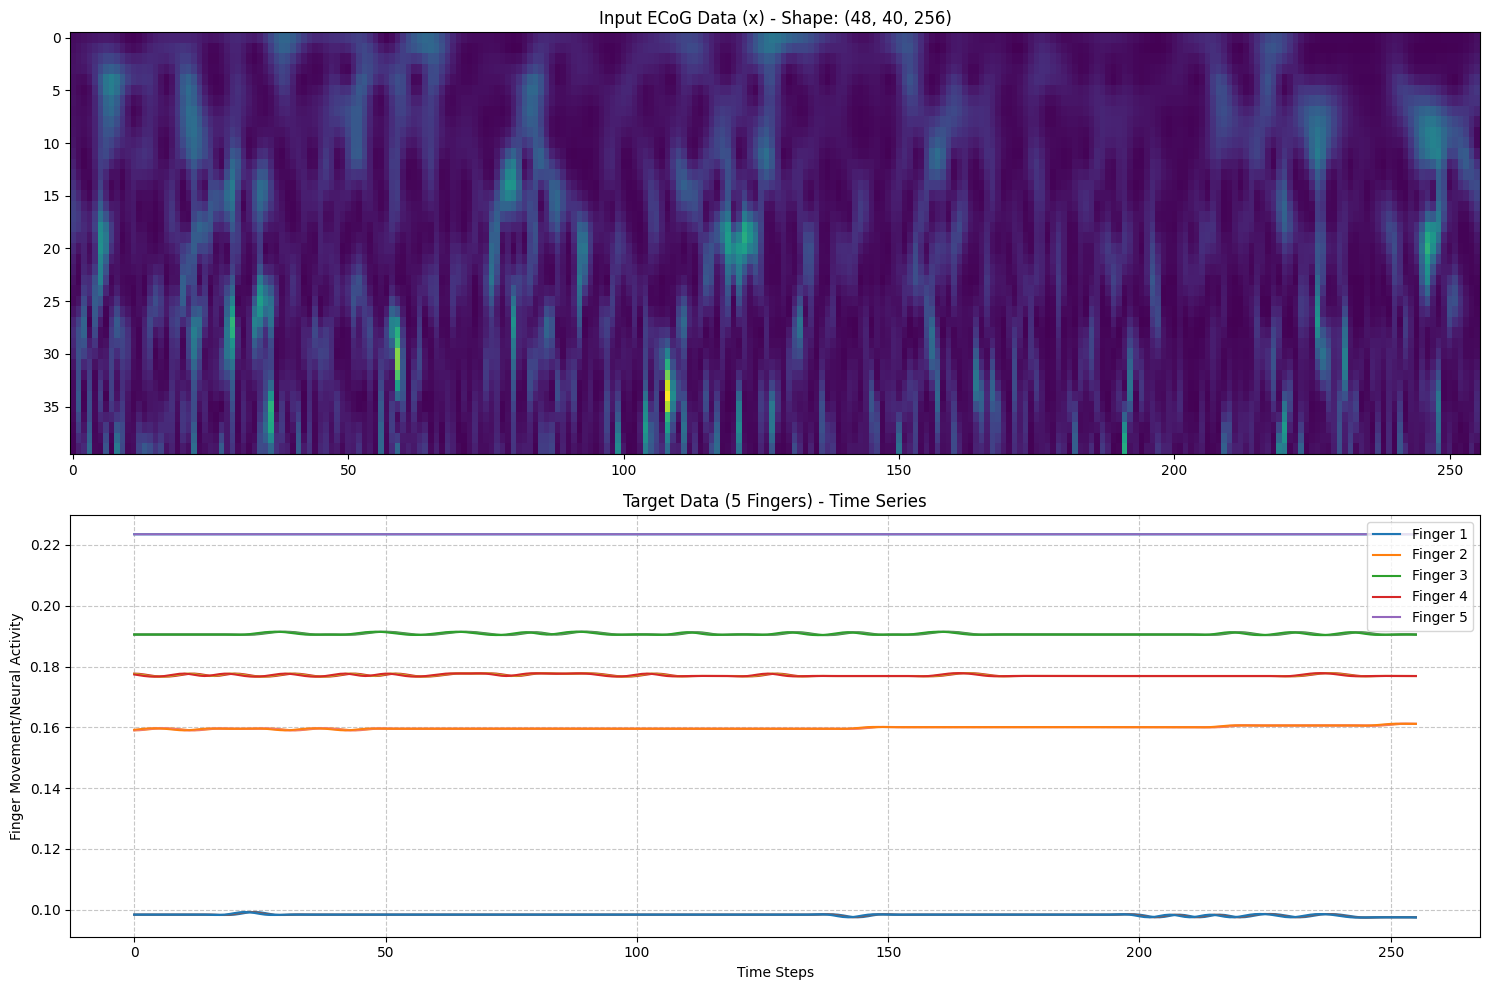

Input (x) Data Statistics:
Shape: (48, 40, 256)
Mean: 26.572364807128906
Std: 96.56010437011719
Min: -78.4576416015625
Max: 1655.322021484375

Target (y) Data Statistics:
Shape: (5, 256)
Mean: 0.16989579796791077
Std: 0.04146142676472664
Min: 0.09741489589214325
Max: 0.2235344499349594


In [18]:
# Call the visualization function
plot_ecog_data(train_dataset)